In [1]:
import numpy as np
import cv2
import os
# %matplotlib notebook
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import operator
from sklearn.cluster import KMeans

In [2]:
def check_colour(img):
    height, width, dim = img.shape

     
    ## convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


    
    ## mask of green 
    mask1 = cv2.inRange(hsv, (36, 0, 0), (70, 255,255))

    ## mask of purple 
    mask2 = cv2.inRange(hsv, (70,0,0), (179, 255, 255))
    
    ## mask of red 
    mask3 = cv2.inRange(hsv, (15,0,0), (36, 255, 255))
    
    ## final mask and masked
    mask = cv2.bitwise_or(mask1, mask2,mask3)
    target = cv2.bitwise_and(img,img, mask=mask)


#     cv2.imshow('result',target)
#     cv2.waitKey(0)
    
#     img_vec = np.reshape(res,[height * width, dim])
 

#     kmeans = KMeans(n_clusters=3)
#     kmeans.fit(img_vec)
#     unique_l, counts_l = np.unique(kmeans.labels_, return_counts=True)
#     sort_ix = np.argsort(counts_l)
#     sort_ix = sort_ix[::-1]
#     for cluster_center in kmeans.cluster_centers_[sort_ix]:
#         print(cluster_center)
    

In [3]:
 def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs(np.dot(d1, d2) / np.sqrt(np.dot(d1, d1)*np.dot(d2, d2)))

def find_cards(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    cards = []

    for gray in cv2.split(img):
        for thrs in range(0, 255, 25):
            if thrs == 0:
                edges = cv2.Canny(gray, 0, 50, apertureSize=5)
#                 cv2.imshow('edges' ,edges)
                bin = cv2.dilate(edges, None)
                
            else:
                retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            bin, contours, hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                
                leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
                rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
                topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
                bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    if max_cos < 0.4 and cv2.contourArea(cnt) < 1000000 and cv2.contourArea(cnt) > 100000:
                        cards.append(cv2.boundingRect(np.array([leftmost, rightmost, topmost, bottommost])))
                    
    return cards

In [4]:
def find_shapes(image):
    
    card_props = {'shape': 0, 'fill': 0, 'number': 0, 'colour': 0}
    
    blur_img = cv2.blur(image, (3, 3))
    gray_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2GRAY)
    thr_image = cv2.Canny(gray_img, 50, 220, apertureSize=3)
    thr_image = cv2.dilate(thr_image, np.ones((3, 3), np.uint8))
    cont_img, contours, hierarchy = cv2.findContours(thr_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     colour = check_colour(image)
   
    for cnt in contours:
        if cv2.contourArea(cnt) > 5000 and cv2.contourArea(cnt) < 200000:
            cv2.drawContours(draw_on, [cnt], 0, (0, 255, 0), 5)
            
#             print(cv2.arcLength(cnt, True))
#             print(cv2.contourArea(cnt))
            epsilon = 0.005*cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            
            
            print(approx.shape)
            if approx.shape[0] == 4:
                card_props['shape'] = 1
                card_props['number'] += 1 
            elif approx.shape[0] < 18:
                card_props['shape'] = 2
                card_props['number'] += 1 
            elif approx.shape[0] >= 19:
                card_props['shape'] = 3
                card_props['number'] += 1
           
              
    return card_props

In [5]:
image_file = '/Users/francis/projects/Set_Game_Computer_Vision/IMG_20190106_161905.jpg'

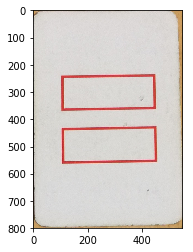

(4, 1, 2)
(4, 1, 2)
{'shape': 1, 'fill': 0, 'number': 2, 'colour': 0}


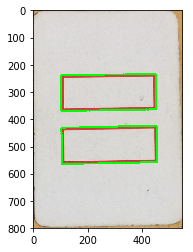

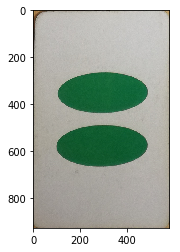

(16, 1, 2)
(16, 1, 2)
{'shape': 2, 'fill': 0, 'number': 2, 'colour': 0}


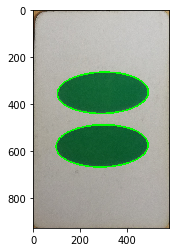

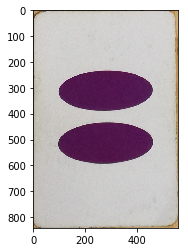

(16, 1, 2)
(16, 1, 2)
{'shape': 2, 'fill': 0, 'number': 2, 'colour': 0}


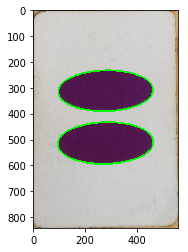

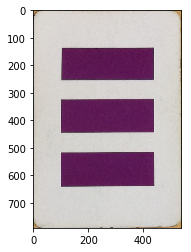

(4, 1, 2)
(4, 1, 2)
(4, 1, 2)
{'shape': 1, 'fill': 0, 'number': 3, 'colour': 0}


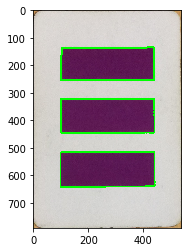

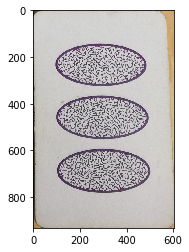

(16, 1, 2)
(16, 1, 2)
(16, 1, 2)
{'shape': 2, 'fill': 0, 'number': 3, 'colour': 0}


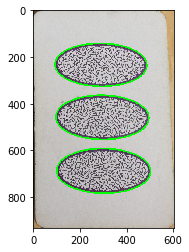

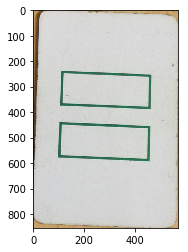

(4, 1, 2)
(4, 1, 2)
{'shape': 1, 'fill': 0, 'number': 2, 'colour': 0}


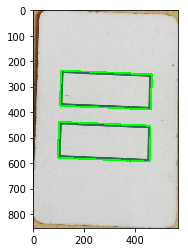

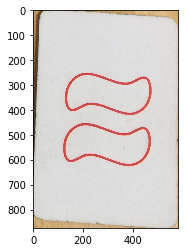

(20, 1, 2)
(19, 1, 2)
{'shape': 3, 'fill': 0, 'number': 2, 'colour': 0}


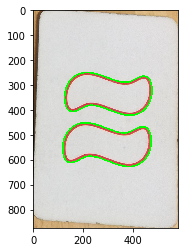

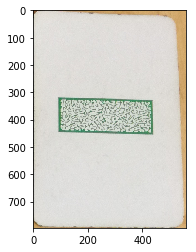

(4, 1, 2)
{'shape': 1, 'fill': 0, 'number': 1, 'colour': 0}


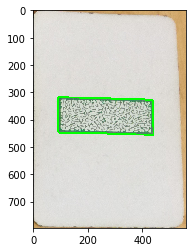

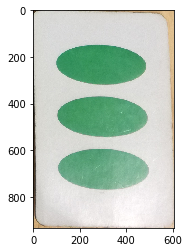

(17, 1, 2)
(15, 1, 2)
(16, 1, 2)
{'shape': 2, 'fill': 0, 'number': 3, 'colour': 0}


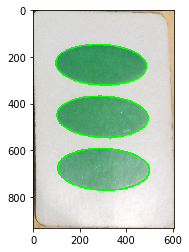

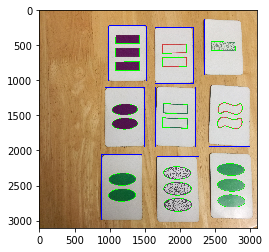

In [7]:
img = cv2.imread(image_file)
img_2 = img[:]
cards = find_cards(img)
cards = cv2.groupRectangles(cards, 1)[0]

for card in cards:
    card_img = img[card[1]:card[1]+card[3], card[0]:card[0]+card[2]]
#     cv2.imshow('thiscard', card_img)
    draw_on = card_img[:]
    plt.imshow(cv2.cvtColor(card_img, cv2.COLOR_BGR2RGB))
    plt.show()

    
    shapes = find_shapes(card_img)
    print(shapes)
    plt.imshow(cv2.cvtColor(draw_on, cv2.COLOR_BGR2RGB))
    plt.show()

    cv2.rectangle(img_2, (card[0], card[1]), (card[0]+card[2], card[1]+card[3]), (255, 0, 0), thickness=2)
# print("Found {num} cards and {shapes} shapes (d={d}, o={o}, s={s}).".format(
#     num=len(cards),
#     shapes=shape_count,
#     s=shape_count["squiggles"],
#     o=shape_count["ovals"],
#     d=shape_count["diamonds"]


# #     plt.imshow(img)
ch = 0xFF & cv2.waitKey()
if ch == 27:
    exit()
    
cv2.waitKey(0)
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('output.jpg', img_2)
cv2.destroyAllWindows()
# cv2.waitKey(1)